## Requests of areas at different scales

### Imports

In [1]:
%matplotlib inline

# Utilities
import geopandas as gpd
import matplotlib.pyplot as plt
import itertools
import tempfile
import numpy as np
from pathlib import Path
from shapely.geometry import MultiLineString, MultiPolygon, Polygon, box, shape

# Sentinel Hub
from sentinelhub import (
    CRS,    
    ByocTile,
    SentinelHubBYOC,
    BBox,
    bbox_to_dimensions,
    BBoxSplitter,
    CustomGridSplitter,
    DataCollection,
    MimeType,
    MosaickingOrder,
    OsmSplitter,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    TileSplitter,
    UtmGridSplitter,
    UtmZoneSplitter,
    read_data,
    SHConfig
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

### Import additional packages

In [2]:
import rioxarray  # noqa: F401 # Its necesary for xarray.open_mfdataset() with engine `rasterio`
import xarray as xr  # It may need Dask library https://docs.dask.org/en/stable/install.html
from matplotlib.patches import Polygon as plt_polygon
from mpl_toolkits.basemap import Basemap  # Available here: https://github.com/matplotlib/basemap

### Set up credentials

In [53]:
SHConfig.get_config_location()

'c:\\Users\\lguardamino\\miniconda3\\envs\\SH_tasks\\lib\\site-packages\\sentinelhub\\config.json'

In [58]:
# Insert your credentials here in case you don't already have them in config.json file:
#SH_CLIENT_ID = ""
#SH_CLIENT_SECRET = ""
#AWS_ACCESS_KEY_ID = "949889f6486042289b27d963993d6ef1"
#AWS_SECRET_ACCESS_KEY = "e36838359a09449293136074209f66f1"

config = SHConfig()
sh_client_id = config.sh_client_id 
sh_client_secret = config.sh_client_secret 
aws_access_key_id = config.aws_access_key_id 
aws_secret_access_key = config.aws_secret_access_key 


#if SH_CLIENT_ID and SH_CLIENT_SECRET:
 #   config.sh_client_id = SH_CLIENT_ID
  #  config.sh_client_secret = SH_CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Sentinel Hub ASYNC API, please provide the credentials (client ID and client secret).")

if not config.aws_access_key_id or not config.aws_secret_access_key:
    print("Warning! To use AWS services,please provide the credentials (access key id and secret access key).")

### Example Request with Process API

We will download data from Landsat 9

In [59]:
bbox = (-3.49,54.83,-2.97, 55.04) 

When the bounding box bounds have been defined, you can initialize the BBox of the area of interest. Using the bbox_to_dimensions utility function, you can provide the desired resolution parameter of the image in meters and obtain the output image shape.

In [60]:
resolution = 20
bbox_wgs84 = BBox(bbox=bbox, crs=CRS.WGS84)
bbox_size = bbox_to_dimensions(bbox_wgs84, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {bbox_size} pixels")

Image shape at 20 m resolution: (1670, 1163) pixels


In [61]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.LANDSAT_OT_L2,
            time_interval=("2022-03-01", "2022-03-01"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=bbox_wgs84,
    size=bbox_size,
    config=config,
)

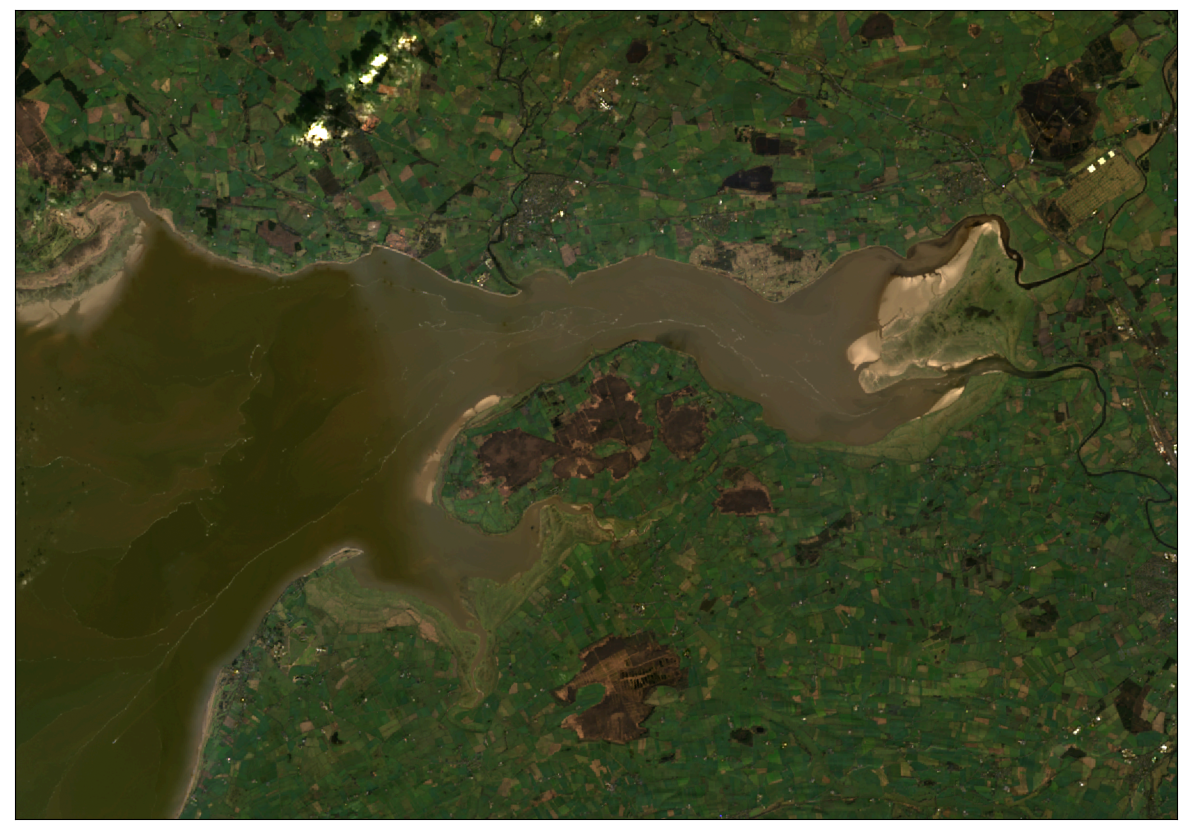

In [62]:
true_color_imgs = request_true_color.get_data()
image = true_color_imgs[0]
# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=4.5 / 255, clip_range=(0, 1))


### Example Request with Asynchronous Processing API

Asynchronous Processing API is currently in beta release. Asynchronous Processing API (or shortly "Async API") allows you to process more data with a single request than Processing API (maximum output image size cannot exceed 10000 pixels). This is possible because the processing results are not returned immediately but are - after some time - delivered in your object storage. We recommend using Async API when you want to process bigger images, when you do not want to deal with tiled results and when it is not crucial for you to get the processing results immediately.

#### Imports

In addition to the previous libraries, a [requests-oauthlib](https://github.com/requests/requests-oauthlib) library is required to handle the retrieval of access tokens using your OAuth Client configuration.

In [63]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

In [73]:
# Create a session
client = BackendApplicationClient(client_id=sh_client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_secret=sh_client_secret)

# All requests using this session will have an access token automatically added
resp = oauth.get("https://services.sentinel-hub.com/oauth/tokeninfo")

#### Create an asynchronous processing request

In [75]:
url = 'https://services.sentinel-hub.com/api/v1/async/process'

evalscript = """
//VERSION=3

function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08"
      ]
    }],
    output: {
      bands: 3
    }
  }
}

let viz = ColorGradientVisualizer.createWhiteGreen();

function evaluatePixel(samples) {
    let ndvi = index(samples.B08, samples.B04);
    vizualizedNdvi = viz.process(ndvi);
    return vizualizedNdvi;
}

"""

payload = {
  "input" : {
    "bounds" : {
      "bbox" : [ 426000, 3960000, 462000, 3994000 ],
      "properties" : {
        "crs" : "http://www.opengis.net/def/crs/EPSG/0/32633"
      }
    },
    "data" : [ {
      "dataFilter" : {
        "timeRange" : {
          "from" : "2022-06-20T00:00:00Z",
          "to" : "2022-06-30T23:59:59Z"
        }
      },
      "type" : "S2L2A"
    } ]
  },
  "output" : {
    "resx" : 10,
    "resy" : 10,
    "responses" : [ {
      "identifier" : "default",
      "format" : {
        "type" : "image/tiff"
      }
    } ],
    "delivery" : {
      "s3" : {
        "url": "s3://async-request-example/example1/",
        "accessKey": "aws_access_key_id",
        "secretAccessKey": "aws_secret_access_key"
      }
    }
  },
  "evalscript" : evalscript
}

headers = {
  'Content-Type': 'application/json'
}

response = oauth.post(url, headers=headers, json=payload)
response.json()

{'id': 'b9876b35-5984-4775-8e6a-4090eee8bbb6', 'status': 'RUNNING'}

In [76]:
request_id = response.json()['id']

In [83]:
response = oauth.get(url=f"{url}/{request_id}")
response.json()

{'error': {'status': 404,
  'reason': 'Not Found',
  'message': 'Not Found',
  'code': 'COMMON_NOT_FOUND'}}

### Example Request with Large Scale Utilities